# Exploratory Notebook

## 1. Prerequisite Cells

In [2]:
# Add the necessary libraries to use
import numpy as np
import pandas as pd

# Necessary commands for the graphs to show up in the notebook on the correct format
%matplotlib inline
import matplotlib.pyplot as plt

#matplotlib style options
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 8)
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 8)

In [3]:
# We start by reading in the dataset from the Excel file
df = pd.read_excel('Households Data.xlsx', sheet_name = 'Hogares')
headers = pd.read_excel('Households Data.xlsx', sheet_name = 'Dictionary')

In [4]:
headers.head()
del headers['Used in Model?']

In [6]:
# We need to change the UTM coordinates into regular latlong-coordinates
#UTM grid zone for Santiago de Chile is 19H

from pyproj import Proj
myProj = Proj("+proj=utm +zone=19H, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
#myProj = Proj("+proj=utm +zone=19H, +south +ellps=WGS84", preserve_units=False)

df['Longitude'],df['Latitude'] = myProj(df['DirCoordX'].values, df['DirCoordY'].values, inverse=True)

#reference: https://ocefpaf.github.io/python4oceanographers/blog/2013/12/16/utm/
#validation = data[:]

In [7]:
import utm
df['Latitude'], df['Longitude'] = utm.to_latlon(df['DirCoordX'].values, df['DirCoordY'].values, 19, northern=False)

In [8]:
data=df[:]
data = data[(data.EXCLUIR ==0)&(data.paraValidacion == 0)]
del data['EXCLUIR']
del data['paraValidacion']


validation = df[df.paraValidacion == 1]
del validation['EXCLUIR']
del validation['paraValidacion']

In [9]:
data_full = data.append(validation)

In [10]:
from scipy import stats
import numpy as np
#all columns with dramatic outliers according to Petra
outlier_cols = ['Acc_Habitacion_auto', 'MontoArr']
z = np.abs(stats.zscore(data_full[outlier_cols]))
threshold = 3

data_full_o = data_full[(z < threshold).all(axis=1)]
data_full = data_full_o

In [11]:
#accessibility features according to the descriptive statistics notebook
accessibility_cols = ['DensConstr_EOD', 'Dist_est_Metro_MC_KM','Tiempo_Com_Stgo','Acc_Comercio_tpte_pub',
                      'Acc_Educacion_tpte_pub','Acc_Habitacion_tpte_pub','Acc_Industria_tpte_pub',
                      'Acc_Servicios_tpte_pub','Acc_Comercio_auto','Acc_Educacion_auto','Acc_Habitacion_auto',
                      'Acc_Industria_auto','Acc_Servicios_auto']

## 2. Research question and main idea

In this notebook the __exploratory part__ of the challenge will be performed, in particular __the following questions will be adressed__:

- How is accessibility distributed across space?
- Are there particular areas that somehow relate to together?
- Can we explain why?

The __main idea__ to approach these questions is the following:
1. __Clustering__ household data according to their accessibility (using all the features from the "accessibility" group, see descriptive statistics notebook)
2. __Visualizing__ accessibility for every data point in a map (using a colour scale)
3. __Identifying__ areas with high and low accessibility
4. __Finding explanations__ for the (un)evenly distributed accessibility across space by visualizing information from an __external data set__:
   - location of __points of transport__, such as roads, metro lines and bus stations
   - location of __points of interest__, such as supermarkets, schools and restaurants  

## 3. Clustering households according to their accessibility

In order to find out how accessibility is distributed across space, the first step is to cluster the properties by using all features that represent accessbility (gained from the descriptive statistics notebook). Afterwards we will plot the properties on a map coloured according to their accessibility cluster and examine if certain clusters are predominant in particular areas.

In [12]:
# Using the features representing accessibility and standardizing them
acc = data_full[accessibility_cols]
acc_mean = acc.mean(axis=0)
acc_std = acc.std(axis=0)
acc_standardized = (acc - acc_mean) / acc_std
acc_standardized.head()

# As high values for "Dist_est_Metro_MC_KM" and "Tiempo_Com_Stgo" mean a low accessibility, we have to invert them
acc_standardized['Dist_est_Metro_MC_KM'] = (acc_standardized['Dist_est_Metro_MC_KM'])*(-1)
acc_standardized['Tiempo_Com_Stgo'] = (acc_standardized['Tiempo_Com_Stgo'])*(-1)

# Renaming and visualising
acc_st = acc_standardized
acc_st.head()

DensConstr_EOD  Dist_est_Metro_MC_KM  Tiempo_Com_Stgo  \
0       -0.708723             -3.537058        -0.554444   
1       -0.765784             -3.174409        -1.308615   
2       -0.829430             -5.578113        -1.258337   
3       -0.829430             -5.578099        -1.258337   
4       -0.649466             -2.958942        -1.811396   

   Acc_Comercio_tpte_pub  Acc_Educacion_tpte_pub  Acc_Habitacion_tpte_pub  \
0              -1.202294               -1.341686                -1.560986   
1              -1.202294               -1.341686                -1.560986   
2              -1.202294               -1.341686                -1.560986   
3              -1.202294               -1.341686                -1.560986   
4              -1.202294               -1.341686                -1.560986   

   Acc_Industria_tpte_pub  Acc_Servicios_tpte_pub  Acc_Comercio_auto  \
0               -1.179548               -1.066601          -2.071922   
1               -1.179548               -1.066601          -2.071922   
2               -1.179548               -1.066601          -2.071922   
3               -1.179548               -1.066601          -2.071922   
4               -1.179548               -1.066601          -2.071922   

   Acc_Educacion_auto  Acc_Habitacion_auto  Acc_Industria_auto  \
0            -2.22291            -2.361194           -2.027265   
1            -2.22291            -2.361194           -2.027265   
2            -2.22291            -2.361194           -2.027265   
3            -2.22291            -2.361194           -2.027265   
4            -2.22291            -2.361194           -2.027265   

   Acc_Servicios_auto  
0            -1.88691  
1            -1.88691  
2            -1.88691  
3            -1.88691  
4            -1.88691

In [13]:
# using K-means for clustering the data

from sklearn.cluster import KMeans
K=7    #chosing a random number of clusters, we will come back to this later
k=KMeans(K)
k.fit(acc_st)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [14]:
# adding the cluster number to the data points
acc_clusters7 = acc_st.copy()
acc_clusters7['cluster']=k.fit_predict(acc_st)
acc_clusters7.head()

DensConstr_EOD  Dist_est_Metro_MC_KM  Tiempo_Com_Stgo  \
0       -0.708723             -3.537058        -0.554444   
1       -0.765784             -3.174409        -1.308615   
2       -0.829430             -5.578113        -1.258337   
3       -0.829430             -5.578099        -1.258337   
4       -0.649466             -2.958942        -1.811396   

   Acc_Comercio_tpte_pub  Acc_Educacion_tpte_pub  Acc_Habitacion_tpte_pub  \
0              -1.202294               -1.341686                -1.560986   
1              -1.202294               -1.341686                -1.560986   
2              -1.202294               -1.341686                -1.560986   
3              -1.202294               -1.341686                -1.560986   
4              -1.202294               -1.341686                -1.560986   

   Acc_Industria_tpte_pub  Acc_Servicios_tpte_pub  Acc_Comercio_auto  \
0               -1.179548               -1.066601          -2.071922   
1               -1.179548               -1.066601          -2.071922   
2               -1.179548               -1.066601          -2.071922   
3               -1.179548               -1.066601          -2.071922   
4               -1.179548               -1.066601          -2.071922   

   Acc_Educacion_auto  Acc_Habitacion_auto  Acc_Industria_auto  \
0            -2.22291            -2.361194           -2.027265   
1            -2.22291            -2.361194           -2.027265   
2            -2.22291            -2.361194           -2.027265   
3            -2.22291            -2.361194           -2.027265   
4            -2.22291            -2.361194           -2.027265   

   Acc_Servicios_auto  cluster  
0            -1.88691        2  
1            -1.88691        2  
2            -1.88691        2  
3            -1.88691        2  
4            -1.88691        2

In order to plot the properties on a map according to their location, we have to get the Latitude/Longitude values back into our dataframe.

In [15]:
coordinate_cols = ['Latitude', 'Longitude']
coordinates = data_full[coordinate_cols]
acc_clusters7 = acc_clusters7.merge(coordinates, left_index=True, right_index=True)
acc_clusters7.head()

DensConstr_EOD  Dist_est_Metro_MC_KM  Tiempo_Com_Stgo  \
0       -0.708723             -3.537058        -0.554444   
1       -0.765784             -3.174409        -1.308615   
2       -0.829430             -5.578113        -1.258337   
3       -0.829430             -5.578099        -1.258337   
4       -0.649466             -2.958942        -1.811396   

   Acc_Comercio_tpte_pub  Acc_Educacion_tpte_pub  Acc_Habitacion_tpte_pub  \
0              -1.202294               -1.341686                -1.560986   
1              -1.202294               -1.341686                -1.560986   
2              -1.202294               -1.341686                -1.560986   
3              -1.202294               -1.341686                -1.560986   
4              -1.202294               -1.341686                -1.560986   

   Acc_Industria_tpte_pub  Acc_Servicios_tpte_pub  Acc_Comercio_auto  \
0               -1.179548               -1.066601          -2.071922   
1               -1.179548               -1.066601          -2.071922   
2               -1.179548               -1.066601          -2.071922   
3               -1.179548               -1.066601          -2.071922   
4               -1.179548               -1.066601          -2.071922   

   Acc_Educacion_auto  Acc_Habitacion_auto  Acc_Industria_auto  \
0            -2.22291            -2.361194           -2.027265   
1            -2.22291            -2.361194           -2.027265   
2            -2.22291            -2.361194           -2.027265   
3            -2.22291            -2.361194           -2.027265   
4            -2.22291            -2.361194           -2.027265   

   Acc_Servicios_auto  cluster   Latitude  Longitude  
0            -1.88691        2 -33.729444 -70.779035  
1            -1.88691        2 -33.737278 -70.744340  
2            -1.88691        2 -33.805994 -70.859656  
3            -1.88691        2 -33.805995 -70.859654  
4            -1.88691        2 -33.722055 -70.743270

In [16]:
#Just to check that nothing got lost
print(len(acc_st))
print(len(coordinates))
print(len(acc_clusters7))
#And to verify that 7 clusters were created
print(set(acc_clusters7['cluster']))

17100
17100
17100
{0, 1, 2, 3, 4, 5, 6}


Let's plot the data points onto a map, coloring them according to their cluster.

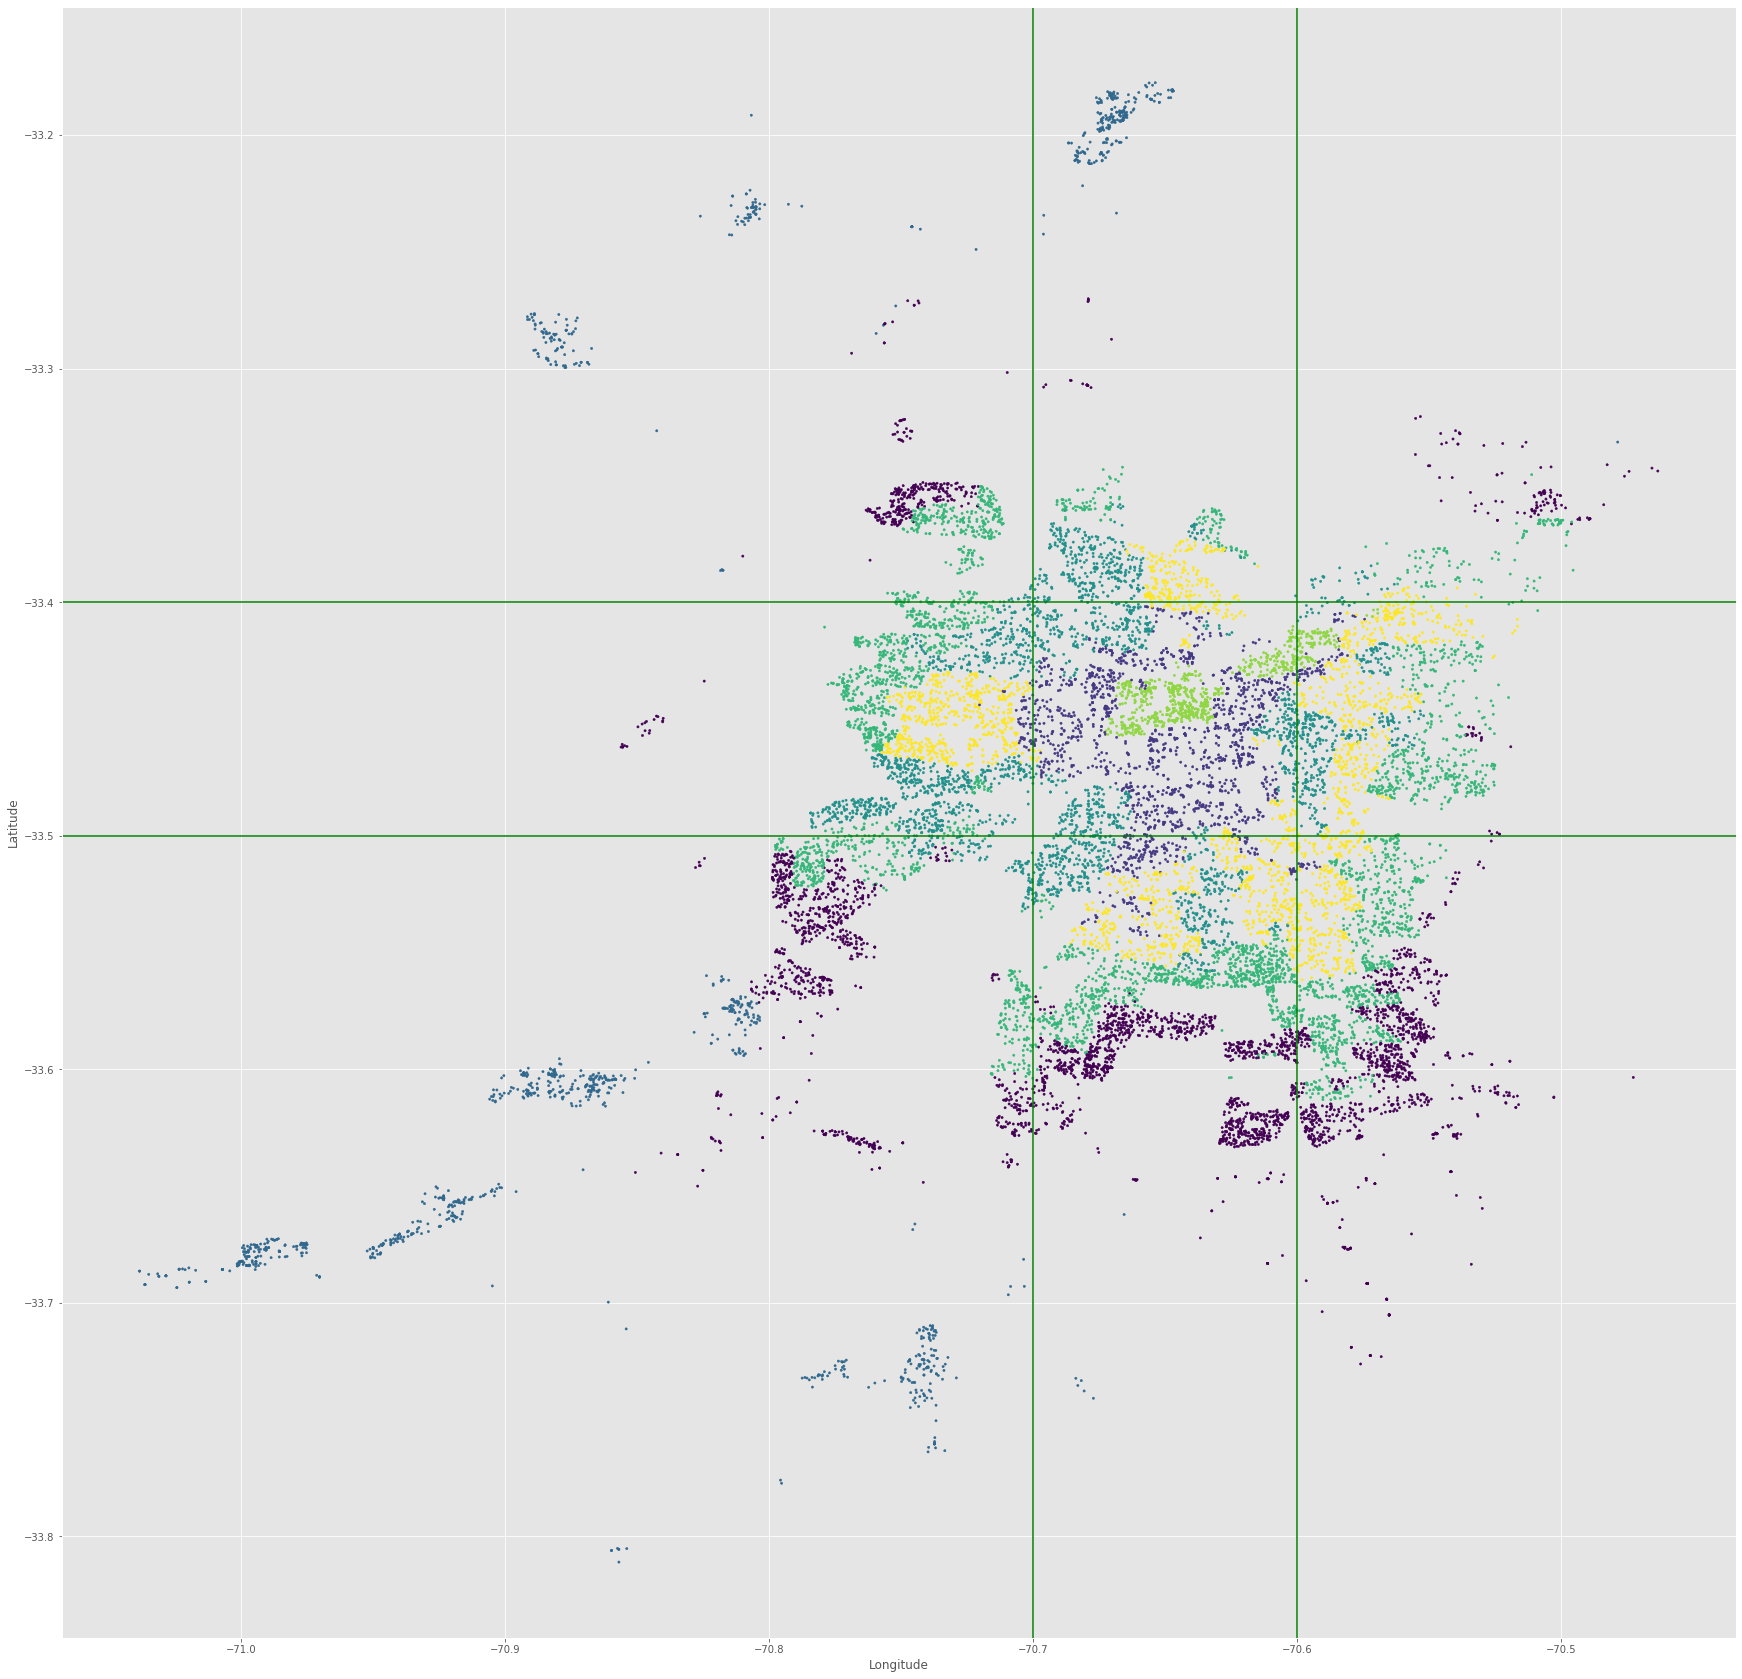

In [17]:
fig = plt.figure(figsize = (30,30))
ax1 = fig.add_subplot(111)

# plot the household datapoints, coloring them according to their accessibility cluster
ax1.scatter(acc_clusters7.Longitude, acc_clusters7.Latitude, s=5, c=acc_clusters7['cluster'])

# indicate the city centre (test set)
plt.axhline(y=-33.4, color='g', linestyle='-')
plt.axhline(y=-33.5, color='g', linestyle='-')
plt.axvline(x=-70.6, color='g', linestyle='-')
plt.axvline(x=-70.7, color='g', linestyle='-')
plt.ylabel('Latitude')
plt.xlabel('Longitude')

plt.show()

It can clearly be seen that objects belonging to the same cluster are located next to each other, they form clouds of the same colour. Also, clusters seem to be distributed concentrical around the city centre. As a next step, we now would like to know, if the "colour clouds" that are located next to each other have a similar accessibility. In other words, we would like to know, what level of accessibility the clusters 0,1,2,3,4,5 and 6 respectively represent. To do this, we group the data by their cluster and see if we can derive some conclusions.

In [18]:
acc_grouped7 = acc_clusters7.groupby('cluster').agg('mean')
acc_grouped7 = acc_grouped7.sort_values(by=['Acc_Servicios_tpte_pub'])
acc_grouped7

DensConstr_EOD  Dist_est_Metro_MC_KM  Tiempo_Com_Stgo  \
cluster                                                          
2             -0.689648             -3.062489        -1.183145   
0             -0.473578             -0.250980        -0.936005   
4             -0.305237              0.164877        -0.121533   
3             -0.048376              0.332862         0.329875   
6             -0.029017              0.557186         0.308088   
1              0.510816              0.566037         1.232057   
5              3.337078              0.626503         1.568473   

         Acc_Comercio_tpte_pub  Acc_Educacion_tpte_pub  \
cluster                                                  
2                    -1.437300               -1.602898   
0                    -0.873830               -0.825631   
4                    -0.454228               -0.400700   
3                     0.060526                0.034528   
6                     0.861320                0.925970   
1                     1.418149                1.375739   
5                     2.087852                1.863371   

         Acc_Habitacion_tpte_pub  Acc_Industria_tpte_pub  \
cluster                                                    
2                      -1.796174               -1.487591   
0                      -0.828416               -0.882022   
4                      -0.329052               -0.427598   
3                       0.097580                0.374846   
6                       0.999186                0.664580   
1                       1.213333                1.485521   
5                       1.693590                1.522424   

         Acc_Servicios_tpte_pub  Acc_Comercio_auto  Acc_Educacion_auto  \
cluster                                                                  
2                     -1.238566          -2.365893           -2.592509   
0                     -0.845539          -0.812660           -0.720011   
4                     -0.484439          -0.111053           -0.048657   
3                      0.007493           0.664142            0.652807   
6                      0.783659           0.375303            0.398171   
1                      1.361625           1.180088            1.101496   
5                      2.332765           1.451199            1.232514   

         Acc_Habitacion_auto  Acc_Industria_auto  Acc_Servicios_auto  \
cluster                                                                
2                  -2.708504           -2.338032           -2.025359   
0                  -0.702036           -0.723372           -0.865242   
4                   0.008365           -0.088122           -0.159937   
3                   0.666648            0.796122            0.626060   
6                   0.455330            0.258900            0.325895   
1                   0.967174            1.123739            1.181748   
5                   1.097386            0.991055            1.673152   

          Latitude  Longitude  
cluster                        
2       -33.518021 -70.833133  
0       -33.559282 -70.660016  
4       -33.493388 -70.655337  
3       -33.460767 -70.675693  
6       -33.471404 -70.635905  
1       -33.461521 -70.648749  
5       -33.437082 -70.634962

Having sorted the dataframe by one arbitrary accessibility feature (in this case Acc_Servicios_tpte_pub was chosen) it can be seen that the sorting makes sense for almost all of the features. It just seems that the mean of some clusters is very similar to other (related) clusters. It might be useful to reduce the number of clusters. To verify this conclusion, an instrument called silhouette score was found, which tells us how far away data points within a cluster are from the other clusters, i.e. it gives a hint how many clusters to use.

In [19]:
#from: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py)

from sklearn.metrics import silhouette_score
n_clusters = (2,3,4,5,6,7,8)
for i in n_clusters:
    clusterer = KMeans (n_clusters=i)
    preds = clusterer.fit_predict(acc_st)

    score = silhouette_score(acc_st, preds, metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {})".format(i, score))

For n_clusters = 2, silhouette score is 0.4070815081439008)
For n_clusters = 3, silhouette score is 0.4137170050562904)
For n_clusters = 4, silhouette score is 0.384406366070883)
For n_clusters = 5, silhouette score is 0.3071698124768765)
For n_clusters = 6, silhouette score is 0.27306588004228316)
For n_clusters = 7, silhouette score is 0.2615120885064784)
For n_clusters = 8, silhouette score is 0.2505217065160295)


Since a higher score is better, we can see that it might be a good idea to either chose two or three clusters. We decide to chose three, as the silhoutte score is slightly higher.

In [20]:
# fit the K-means clustering method
K=3
k=KMeans(K)
k.fit(acc_st)

# create the clusters, add them as a separate column to the data points, add the coordinates and aggregate the data
acc_clusters3 = acc_st.copy()
acc_clusters3['cluster']=k.fit_predict(acc_st)
acc_clusters3 = acc_clusters3.merge(coordinates, left_index=True, right_index=True)
acc_grouped3 = acc_clusters3.groupby('cluster').agg('mean')
acc_grouped3 = acc_grouped3.sort_values(by=['Acc_Servicios_tpte_pub'])
acc_grouped3

DensConstr_EOD  Dist_est_Metro_MC_KM  Tiempo_Com_Stgo  \
cluster                                                          
2             -0.701529             -2.916128        -1.188941   
1             -0.361272              0.045092        -0.414852   
0              0.603011              0.508180         0.766909   

         Acc_Comercio_tpte_pub  Acc_Educacion_tpte_pub  \
cluster                                                  
2                    -1.432187               -1.593102   
1                    -0.549677               -0.508497   
0                     0.988344                0.966398   

         Acc_Habitacion_tpte_pub  Acc_Industria_tpte_pub  \
cluster                                                    
2                      -1.776174               -1.476164   
1                      -0.455986               -0.505450   
0                       0.934118                0.939748   

         Acc_Servicios_tpte_pub  Acc_Comercio_auto  Acc_Educacion_auto  \
cluster                                                                  
2                     -1.236996          -2.288811           -2.506076   
1                     -0.563711          -0.318321           -0.243504   
0                      0.968560           0.855838            0.801381   

         Acc_Habitacion_auto  Acc_Industria_auto  Acc_Servicios_auto  \
cluster                                                                
2                  -2.614026           -2.245498           -1.964294   
1                  -0.197930           -0.232274           -0.380816   
0                   0.763470            0.736257            0.873543   

          Latitude  Longitude  
cluster                        
2       -33.520792 -70.828184  
1       -33.517005 -70.661495  
0       -33.458359 -70.644861

In [21]:
# to find out which cluster represents high, low and medium accessibility:
high_acc_cluster = acc_grouped3.DensConstr_EOD.idxmax()
low_acc_cluster = acc_grouped3.DensConstr_EOD.idxmin()

med_acc_cluster = 0

if high_acc_cluster == 0:
    if low_acc_cluster == 1:
        med_acc_cluster = 2
    else:
        med_acc_cluster = 1
else:
    if high_acc_cluster == 1:
        if low_acc_cluster == 2:
            med_acc_cluster = 0
        else:
            med_acc_cluster = 2
    else:
        if low_acc_cluster == 1:
            med_acc_cluster = 0
        else:
            med_acc_cluster = 1

print('Now it can be clearly seen that, across all features:')
print(' - Cluster', low_acc_cluster, 'represents a low accessibility')
print(' - Cluster', med_acc_cluster, 'represents a medium accessibility')
print(' - Cluster', high_acc_cluster, 'represents a high accessibility')

Now it can be clearly seen that, across all features:
 - Cluster 2 represents a low accessibility
 - Cluster 1 represents a medium accessibility
 - Cluster 0 represents a high accessibility


Let's plot this onto a map. A green color scale will be used, the darker the color the higher the accessibility.

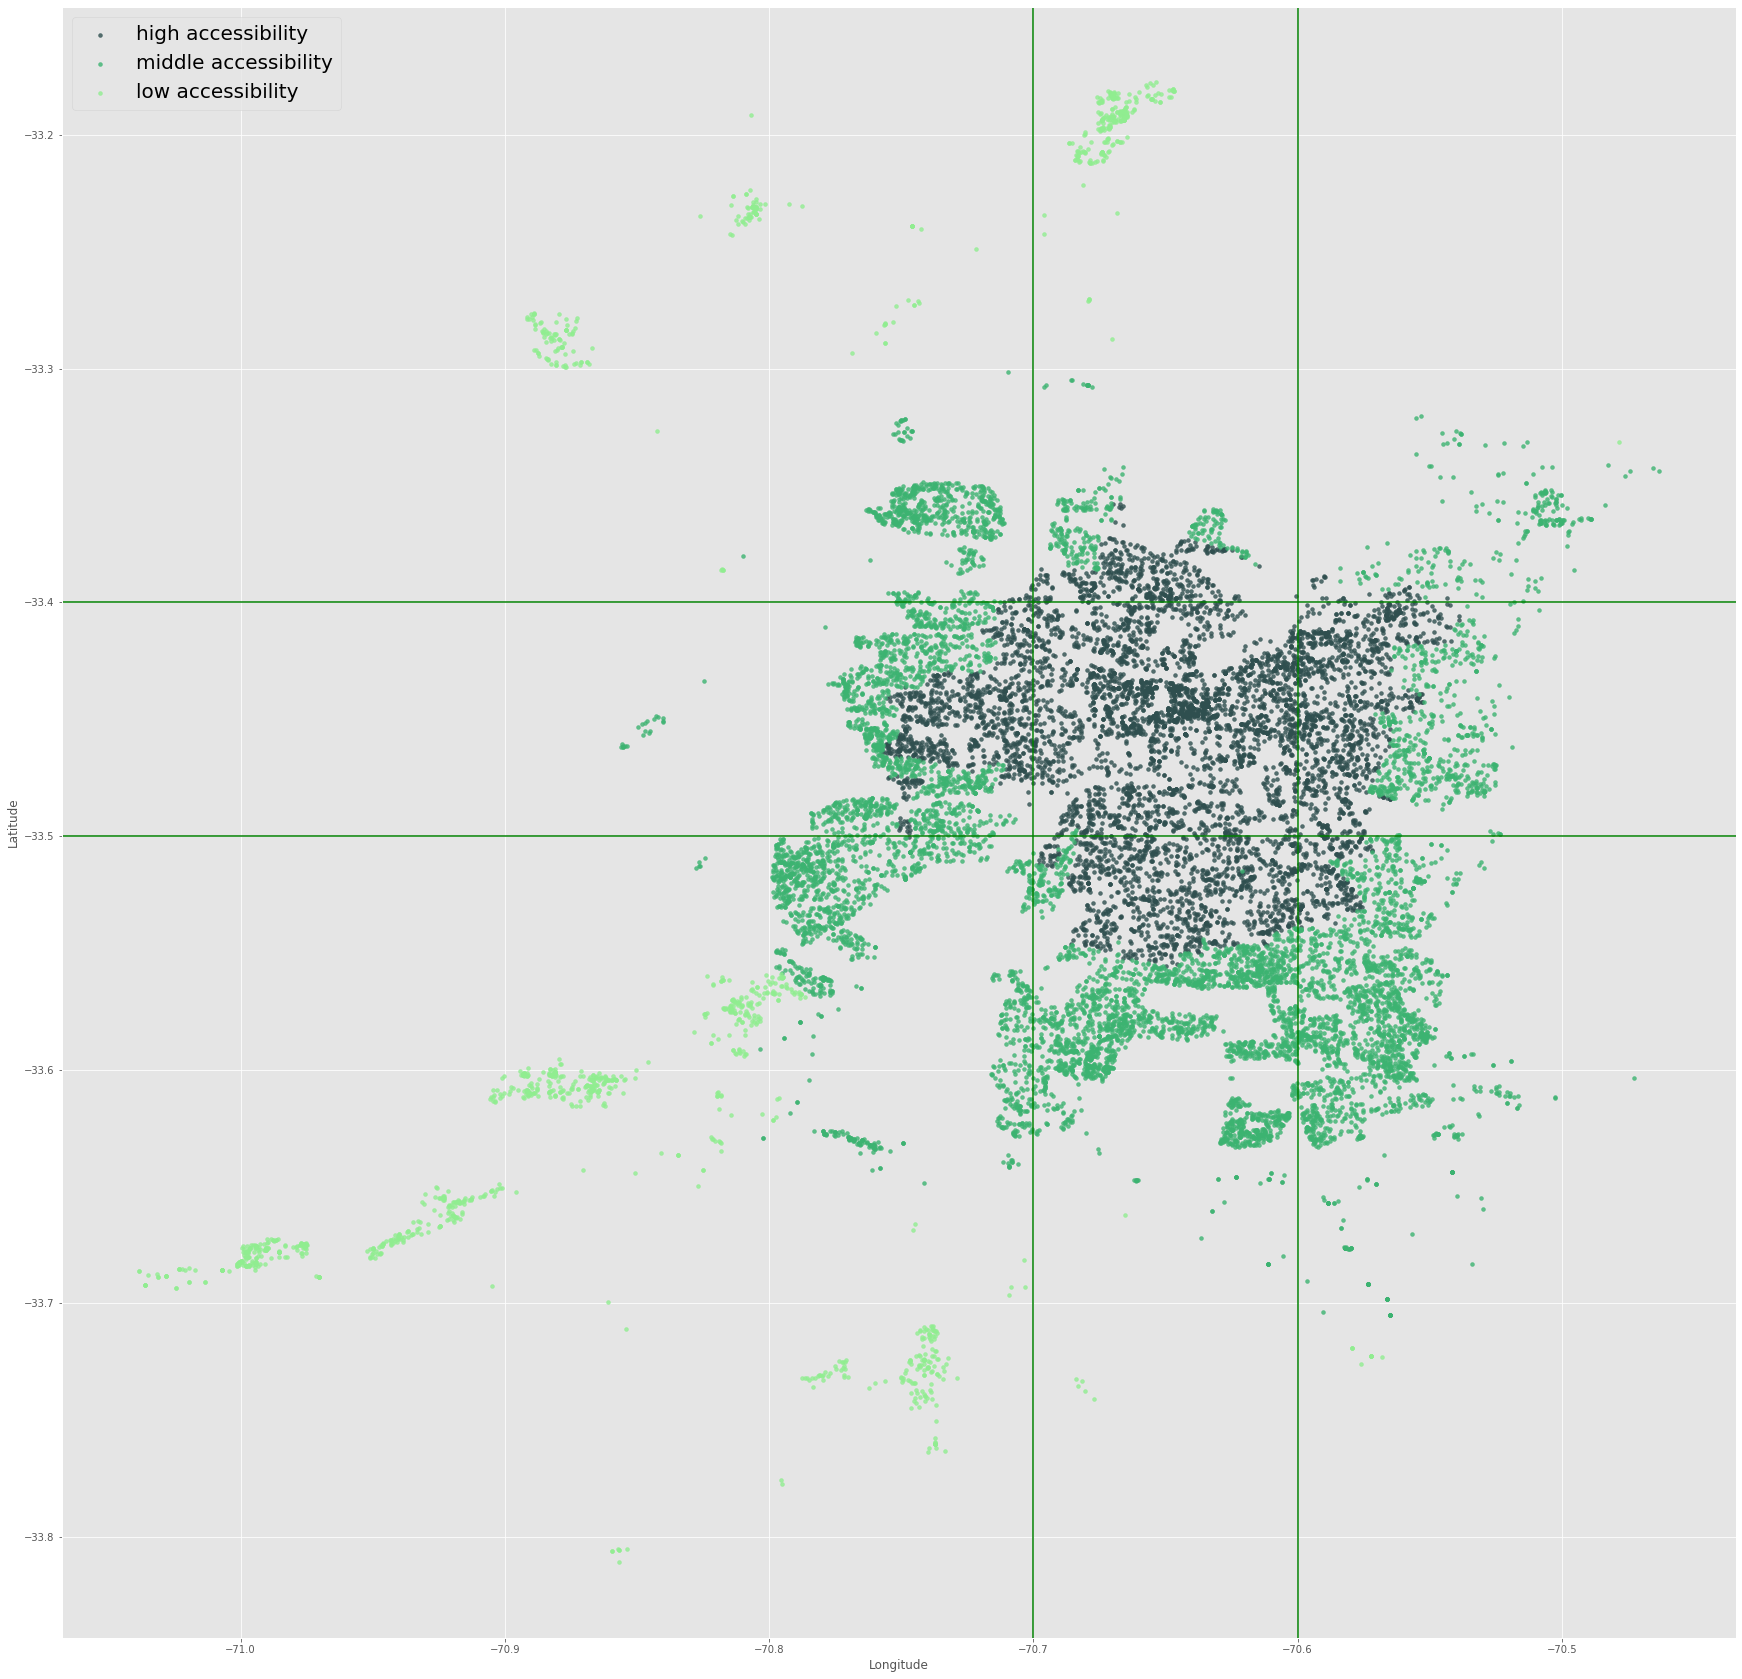

In [22]:
fig = plt.figure(figsize = (30,30))
ax1 = fig.add_subplot(111)

# plot the household datapoints, coloring them according to their accessibility cluster
ax1.scatter(acc_clusters3.Longitude[(acc_clusters3.cluster == high_acc_cluster)], acc_clusters3.Latitude[(acc_clusters3.cluster == high_acc_cluster)], s=15, c='darkslategrey', label='high accessibility', alpha = 0.8)
ax1.scatter(acc_clusters3.Longitude[(acc_clusters3.cluster == med_acc_cluster)], acc_clusters3.Latitude[(acc_clusters3.cluster == med_acc_cluster)], s=15, c='mediumseagreen', label='middle accessibility', alpha = 0.8)
ax1.scatter(acc_clusters3.Longitude[(acc_clusters3.cluster == low_acc_cluster)], acc_clusters3.Latitude[(acc_clusters3.cluster == low_acc_cluster)], s=15, c='lightgreen', label='low accessibility', alpha = 0.8)

# indicate the city centre (test set)
plt.axhline(y=-33.4, color='green', linestyle='-')
plt.axhline(y=-33.5, color='green', linestyle='-')
plt.axvline(x=-70.6, color='green', linestyle='-')
plt.axvline(x=-70.7, color='green', linestyle='-')

plt.ylabel('Latitude')
plt.xlabel('Longitude')

plt.legend(loc='upper left', fontsize=20)
plt.show()

Now we have a better insight into the accessibility distribution across space and the following conclusions can be drawn:
- Objects located close to the city centre have a high accessibility, whereas objects located far away from the city centre have a low accessibility. Accessibility seems to be distributed concentrical around the city centre.
- Objects that have a similar accessibility are located next to each other. I.e. the dark green area borders the mediumgreen area but never the lightgreen area.    

All in all, the improved plot verifies the assumptions from the first plot.

## 4. Explaning the accessibility distribution

Having gained these insight, we now would like to explain _why_ accessibility is distributed like this. In order to do this, we use our external data set. Firstly, we would like to see, if particular transportation objects that increase accessibility (such as railways, motorways, bus stops etc.) are more common in areas where accessibility is high. Secondly, it is examined how certain points of interest (such as schools, restaurants, sights etc.) are distributed across space to see if their density is higher in areas with high accessibility.

### 4.1 Accessibility to transport

First, the external data sets that contain information about objects related to transportation accessibility are read.

In [23]:
import geopandas as gpd # Import geopandas library

railways = gpd.read_file('gis_osm_railways_free_1.shp')
roads = gpd.read_file('gis_osm_roads_free_1.shp')
transport = gpd.read_file('gis_osm_transport_free_1.shp')

In [24]:
railways.fclass.unique()

array(['rail', 'narrow_gauge', 'subway', 'funicular', 'rack', 'tram',
       'miniature_railway'], dtype=object)

In [25]:
roads.fclass.unique()

array(['unclassified', 'secondary', 'residential', 'secondary_link',
       'primary', 'tertiary', 'living_street', 'primary_link',
       'motorway_link', 'motorway', 'cycleway', 'pedestrian', 'service',
       'track', 'footway', 'path', 'trunk', 'tertiary_link', 'trunk_link',
       'steps', 'track_grade4', 'bridleway', 'track_grade2',
       'track_grade3', 'track_grade1', 'track_grade5', 'unknown'],
      dtype=object)

In [26]:
transport.fclass.unique()

array(['ferry_terminal', 'railway_station', 'bus_stop', 'bus_station',
       'taxi', 'railway_halt', 'tram_stop'], dtype=object)

As it can be seen above, the external data sets contain a lot of information about railways, roads and transportation. Not all of the features will be relevant to explain accessibility so only the ones are considered, that seem to be most relevant. In this case only rail, subway, motorway and primary road are selected.

Now let's plot together the households and all the transportation information we have chosen. To not make the plots too confusing, we start with the roads and railways and afterwards continue with the bus data.

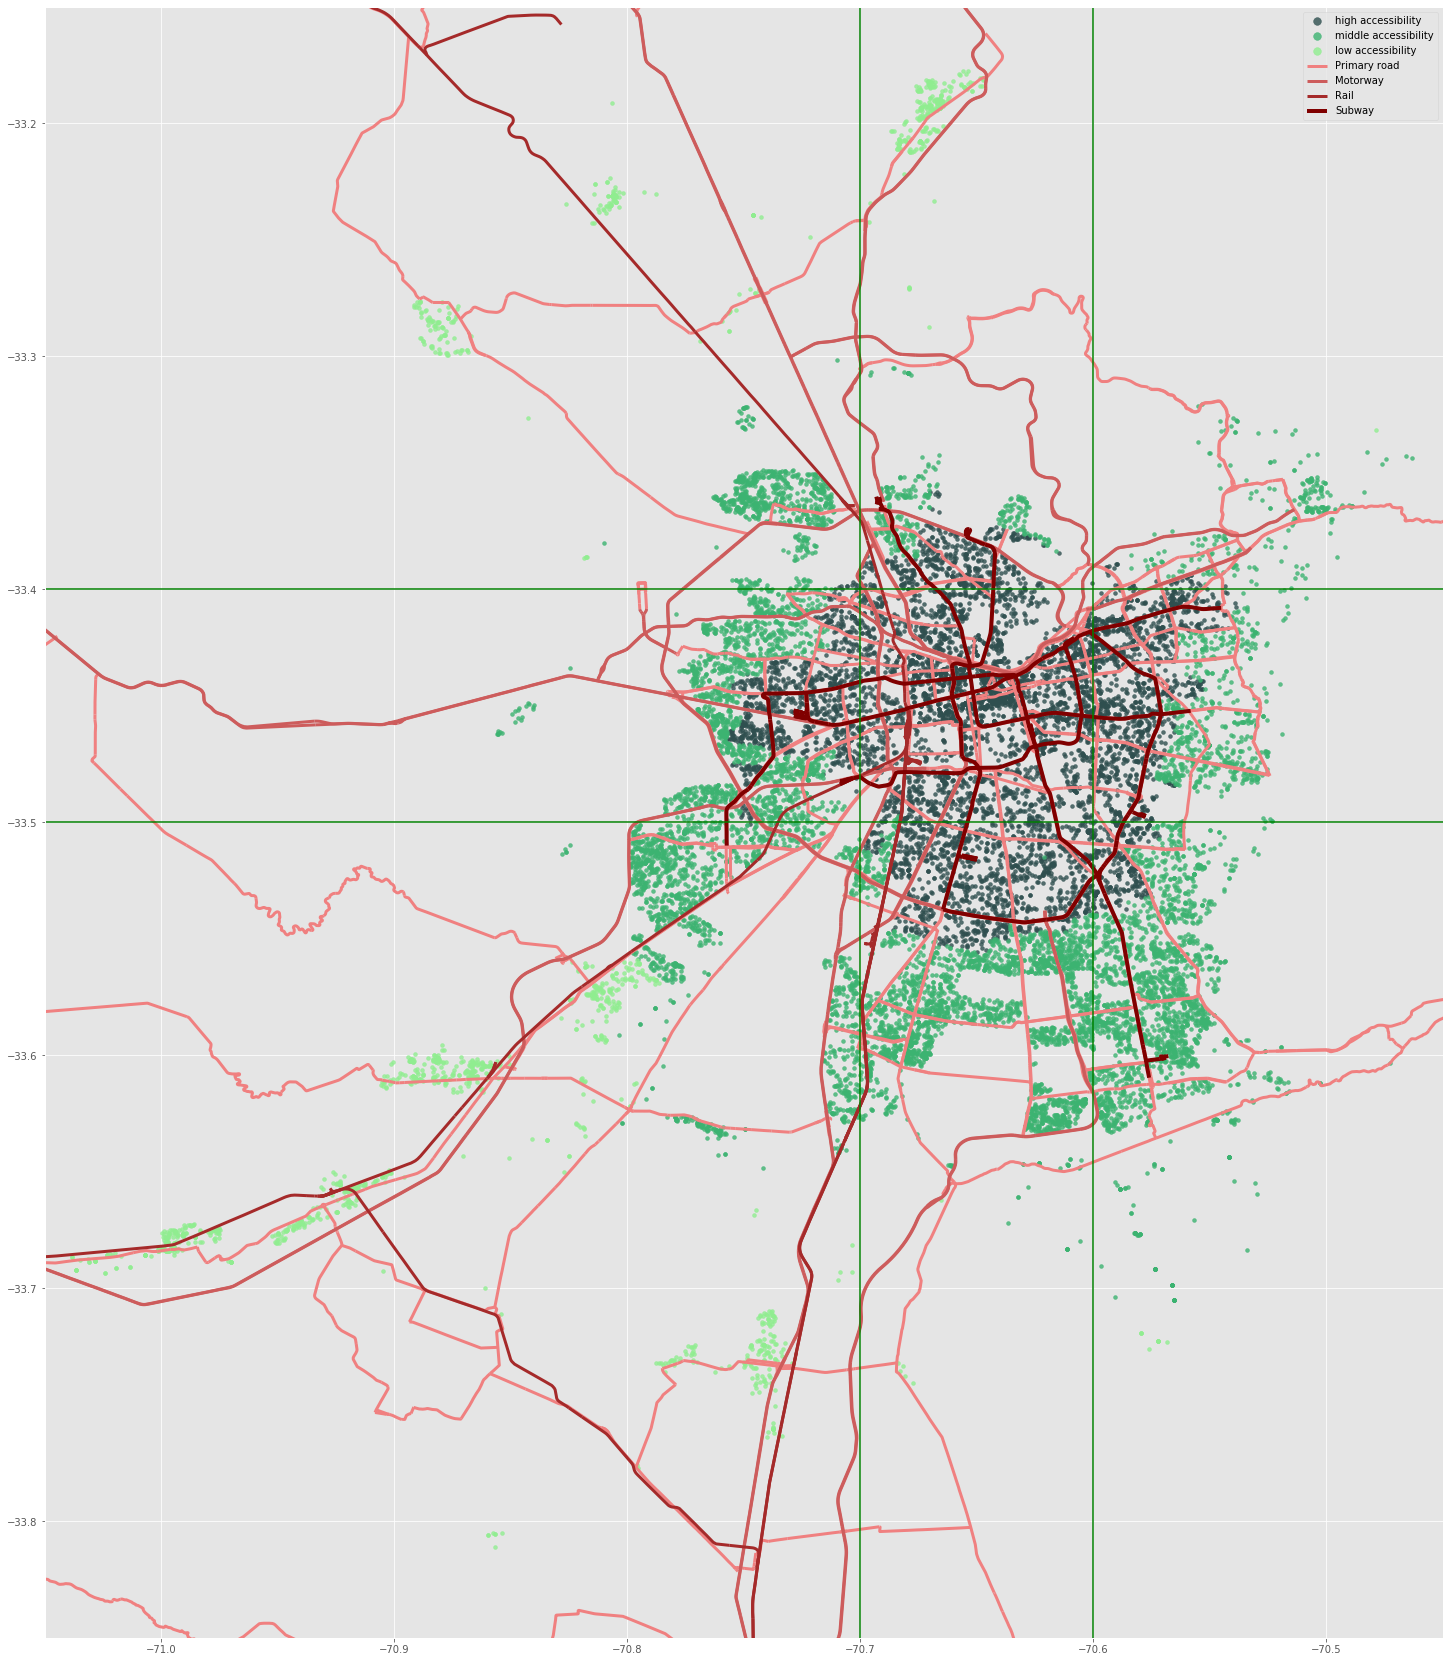

In [27]:
fig, ax = plt.subplots(figsize=(30,30))

ax.set_aspect('equal')

#zones.plot(ax=ax, color='whitesmoke')

# plot the household datapoints, coloring them according to their accessibility cluster
ax.scatter(acc_clusters3.Longitude[(acc_clusters3.cluster == high_acc_cluster)], acc_clusters3.Latitude[(acc_clusters3.cluster == high_acc_cluster)], s=15, c='darkslategrey', label='high accessibility', alpha = 0.8)
ax.scatter(acc_clusters3.Longitude[(acc_clusters3.cluster == med_acc_cluster)], acc_clusters3.Latitude[(acc_clusters3.cluster == med_acc_cluster)], s=15, c='mediumseagreen', label='middle accessibility', alpha = 0.8)
ax.scatter(acc_clusters3.Longitude[(acc_clusters3.cluster == low_acc_cluster)], acc_clusters3.Latitude[(acc_clusters3.cluster == low_acc_cluster)], s=15, c='lightgreen', label='low accessibility', alpha = 0.8)

# plot the transportation data onto the households
roads[roads.fclass=='primary'].plot(ax=ax, color='lightcoral', linewidth=3, label='Primary road', alpha=1)
roads[roads.fclass=='motorway'].plot(ax=ax, color='indianred', linewidth=3, label='Motorway', alpha=1)
railways[railways.fclass=='rail'].plot(ax=ax, color='brown', linewidth=3, label='Rail', alpha=1)
railways[railways.fclass=='subway'].plot(ax=ax, color='maroon', linewidth=4, label='Subway', alpha=1)

# indicate the city centre (test set)
plt.axhline(y=-33.4, color='green', linestyle='-')
plt.axhline(y=-33.5, color='green', linestyle='-')
plt.axvline(x=-70.6, color='green', linestyle='-')
plt.axvline(x=-70.7, color='green', linestyle='-')

ax.legend( markerscale=2, fontsize=10)

ax.set_xlim([-71.05, -70.45])
ax.set_ylim([-33.85, -33.15])

plt.show();

It can clearly be seen that households with low accessibility (light green data points) are not very well conntected to the transportation network. Most of these areas only have access to a few primary roads and sometimes a railway line.  
In contrast, areas with high accessibility (dark green data points) are located where the net of railway, roads and subway is most dense. Particularly the subway network (thick dark red lines) seems to give a very good indication for accessibility, it almost exactly matches the cloud of dark green data points and even seems to border it in the southeastern part of the city. Let's have a closer look at the city centre to verify these findings.

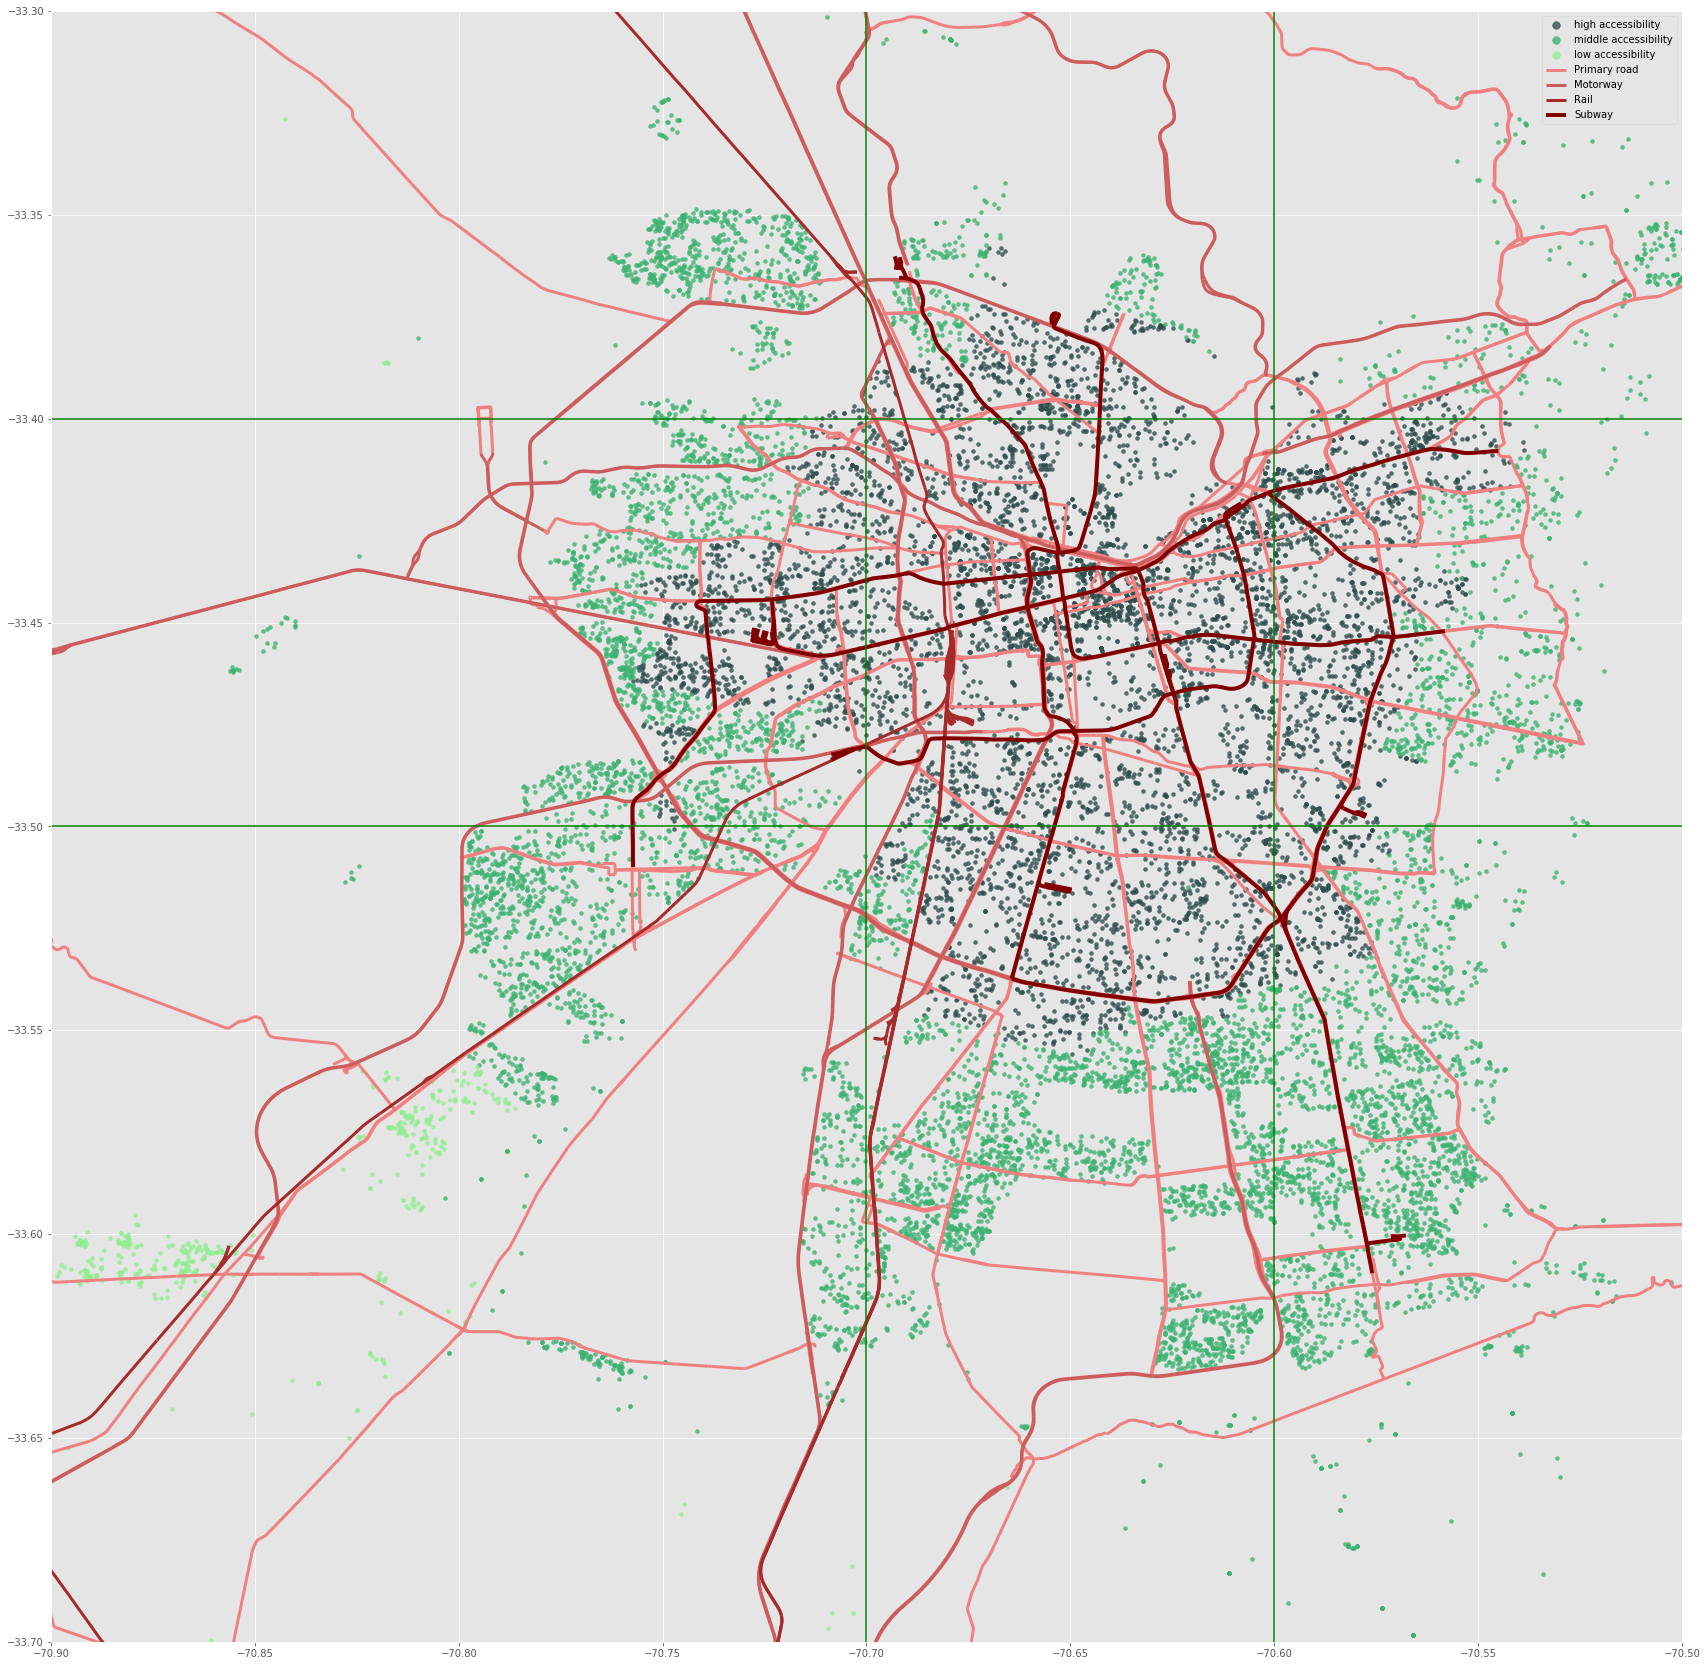

In [28]:
fig, ax = plt.subplots(figsize=(30,30))

ax.set_aspect('equal')

# plot the household datapoints, coloring them according to their accessibility cluster
ax.scatter(acc_clusters3.Longitude[(acc_clusters3.cluster == high_acc_cluster)], acc_clusters3.Latitude[(acc_clusters3.cluster == high_acc_cluster)], s=15, c='darkslategrey', label='high accessibility', alpha = 0.8)
ax.scatter(acc_clusters3.Longitude[(acc_clusters3.cluster == med_acc_cluster)], acc_clusters3.Latitude[(acc_clusters3.cluster == med_acc_cluster)], s=15, c='mediumseagreen', label='middle accessibility', alpha = 0.8)
ax.scatter(acc_clusters3.Longitude[(acc_clusters3.cluster == low_acc_cluster)], acc_clusters3.Latitude[(acc_clusters3.cluster == low_acc_cluster)], s=15, c='lightgreen', label='low accessibility', alpha = 0.8)

# plot the transportation data onto the households
roads[roads.fclass=='primary'].plot(ax=ax, color='lightcoral', linewidth=3, label='Primary road', alpha=1)
roads[roads.fclass=='motorway'].plot(ax=ax, color='indianred', linewidth=3, label='Motorway', alpha=1)
railways[railways.fclass=='rail'].plot(ax=ax, color='brown', linewidth=3, label='Rail', alpha=1)
railways[railways.fclass=='subway'].plot(ax=ax, color='maroon', linewidth=4, label='Subway', alpha=1)

# indicate the city centre (test set)
plt.axhline(y=-33.4, color='green', linestyle='-')
plt.axhline(y=-33.5, color='green', linestyle='-')
plt.axvline(x=-70.6, color='green', linestyle='-')
plt.axvline(x=-70.7, color='green', linestyle='-')

ax.legend( markerscale=2, fontsize=10)

ax.set_xlim([-70.9, -70.5])
ax.set_ylim([-33.7, -33.3])

plt.show();

Next, the bus network is taken into consideration. Let's plot the bus stops and larger bus stations in a dark red colour onto the map.

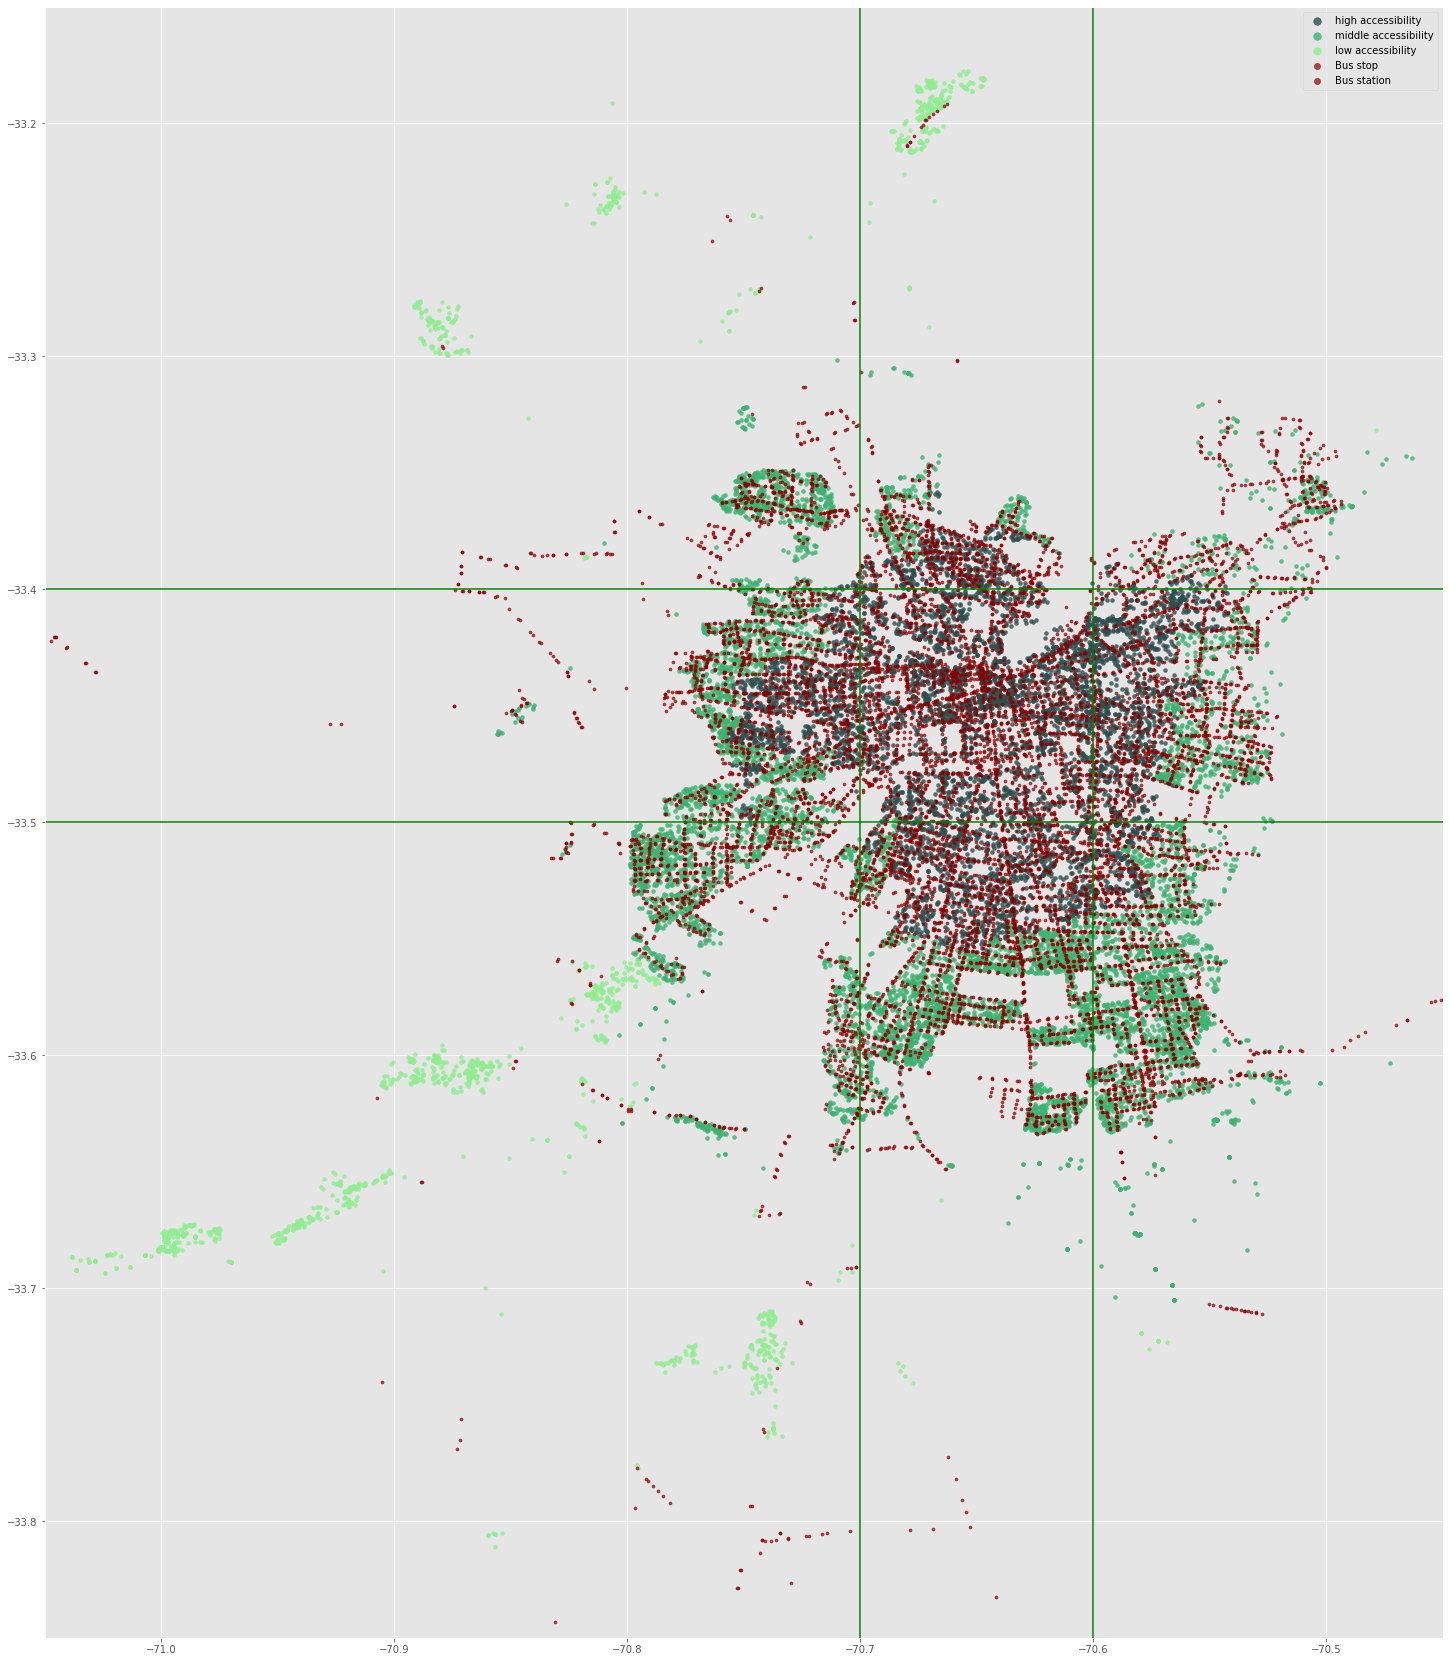

In [29]:
fig, ax = plt.subplots(figsize=(30,30))

ax.set_aspect('equal')
#ax.set_facecolor('whitesmoke')

#zones.plot(ax=ax, color="darkgrey")

# plot the household datapoints, coloring them according to their accessibility cluster
ax.scatter(acc_clusters3.Longitude[(acc_clusters3.cluster == high_acc_cluster)], acc_clusters3.Latitude[(acc_clusters3.cluster == high_acc_cluster)], s=15, c='darkslategrey', label='high accessibility', alpha = 0.8)
ax.scatter(acc_clusters3.Longitude[(acc_clusters3.cluster == med_acc_cluster)], acc_clusters3.Latitude[(acc_clusters3.cluster == med_acc_cluster)], s=15, c='mediumseagreen', label='middle accessibility', alpha = 0.8)
ax.scatter(acc_clusters3.Longitude[(acc_clusters3.cluster == low_acc_cluster)], acc_clusters3.Latitude[(acc_clusters3.cluster == low_acc_cluster)], s=15, c='lightgreen', label='low accessibility', alpha = 0.8)

# plot the bus stops and bus stations onto the households
transport[transport.fclass=='bus_stop'].plot(ax=ax, marker='o', color='darkred', markersize=10, label='Bus stop', alpha=0.7)
transport[transport.fclass=='bus_station'].plot(ax=ax, marker='o', color='darkred', markersize=10, label='Bus station', alpha=0.7)

# indicate the city centre (test set)
plt.axhline(y=-33.4, color='green', linestyle='-')
plt.axhline(y=-33.5, color='green', linestyle='-')
plt.axvline(x=-70.6, color='green', linestyle='-')
plt.axvline(x=-70.7, color='green', linestyle='-')

ax.legend( markerscale=2, fontsize=10)

ax.set_xlim([-71.05, -70.45])
ax.set_ylim([-33.85, -33.15])

plt.show();

Again, it can be seen that the area with high accessibility (dark green) has a very high density of bus stops and stations whereas the areas with low accessibility (light green) have almost no bus stops closeby. The medium green area's density of bus stops seems to be somewhere in between. These are further explanations for the fact that accessibility is not evenly distributed across space.

### 4.2 Accessibility to points of interest

After having gained these interesting insights, it might be a good idea to also have a look at the location of the major points of interest of Santiago de Chile and to see how these relate with the accessibility distribution.  

In [30]:
pois = gpd.read_file('gis_osm_pois_free_1.shp')

In [31]:
pois.fclass.unique()

array(['optician', 'viewpoint', 'pub', 'library', 'sports_centre',
       'attraction', 'museum', 'pharmacy', 'bank', 'fire_station',
       'university', 'supermarket', 'hostel', 'hotel', 'camp_site',
       'fast_food', 'police', 'hospital', 'restaurant', 'convenience',
       'atm', 'cafe', 'water_tower', 'school', 'town_hall',
       'tourist_info', 'post_office', 'toilet', 'arts_centre',
       'doityourself', 'cinema', 'monument', 'courthouse', 'telephone',
       'chalet', 'shelter', 'picnic_site', 'battlefield',
       'wayside_shrine', 'nightclub', 'bakery', 'bicycle_shop', 'artwork',
       'swimming_pool', 'department_store', 'public_building',
       'beverages', 'memorial', 'alpine_hut', 'doctors', 'lighthouse',
       'playground', 'car_dealership', 'computer_shop', 'butcher',
       'laundry', 'kindergarten', 'theatre', 'veterinary', 'guesthouse',
       'wayside_cross', 'college', 'archaeological', 'bar', 'florist',
       'waste_basket', 'kiosk', 'mall', 'bicycle_renta

Once more, there exist plenty of options to chose from. As before, a selection of features considered to be most relevant for accessibility is extracted and plotted onto a map (using a dark pink colour) together with the household data.

In [32]:
# create a list of points of interest that are considered to be most relevant
poi = ['library',  'sports_centre', 'museum', 'pharmacy', 'bank', 'supermarket',
       'fast_food', 'hospital', 'restaurant', 'cafe', 'school', 'doctors','playground',
       'kindergarten', 'theatre', 'college', 'bar', 'mall', 'dentist','clothes']
pois_new = pois.loc[(pois.fclass.isin(poi))].reset_index()

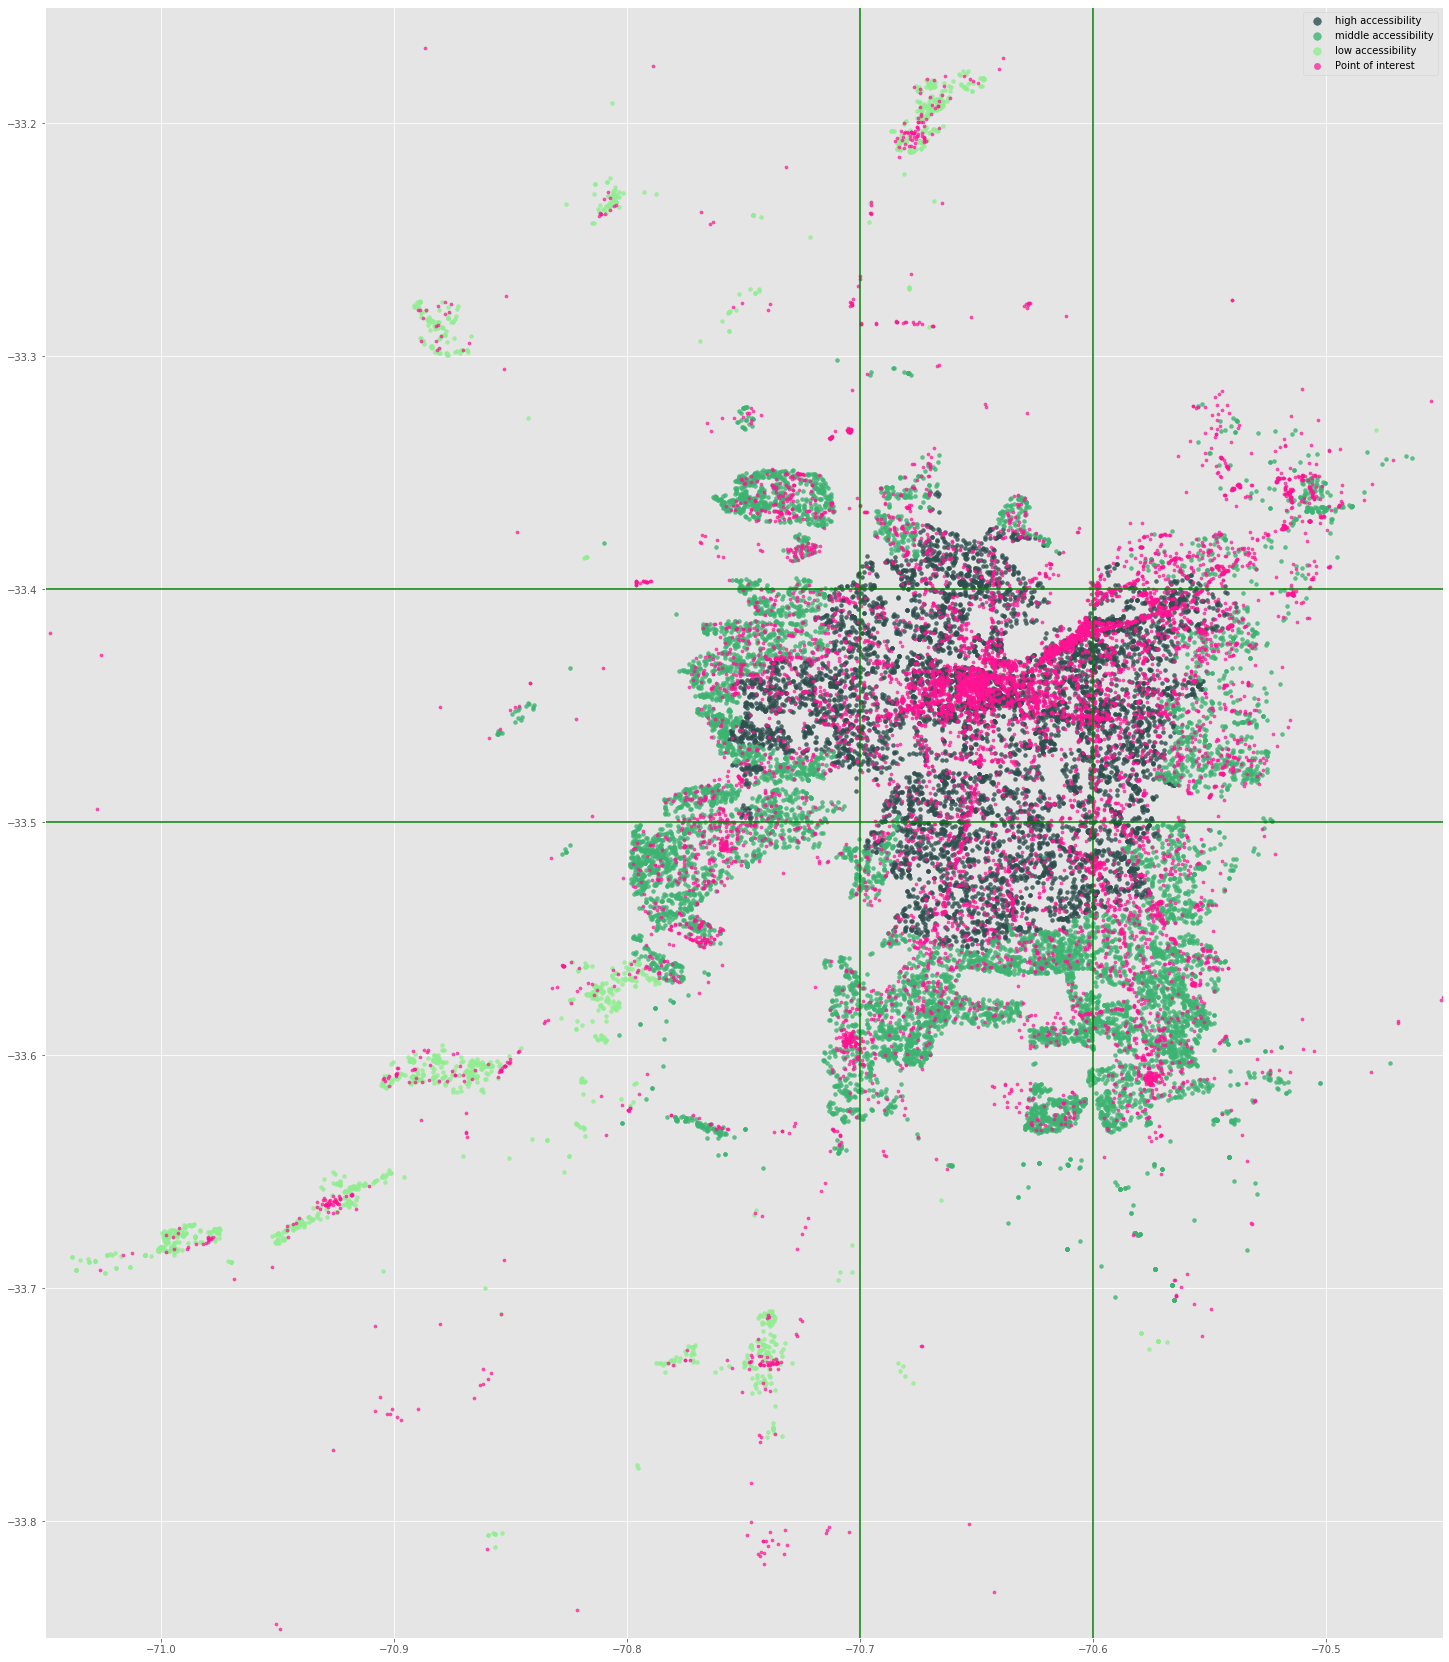

In [33]:
fig, ax = plt.subplots(figsize=(30,30))

ax.set_aspect('equal')
#ax.set_facecolor('whitesmoke')

#zones.plot(ax=ax, color="darkgrey")

# plot the household datapoints, coloring them according to their accessibility cluster
ax.scatter(acc_clusters3.Longitude[(acc_clusters3.cluster == high_acc_cluster)], acc_clusters3.Latitude[(acc_clusters3.cluster == high_acc_cluster)], s=15, c='darkslategrey', label='high accessibility', alpha = 0.8)
ax.scatter(acc_clusters3.Longitude[(acc_clusters3.cluster == med_acc_cluster)], acc_clusters3.Latitude[(acc_clusters3.cluster == med_acc_cluster)], s=15, c='mediumseagreen', label='middle accessibility', alpha = 0.8)
ax.scatter(acc_clusters3.Longitude[(acc_clusters3.cluster == low_acc_cluster)], acc_clusters3.Latitude[(acc_clusters3.cluster == low_acc_cluster)], s=15, c='lightgreen', label='low accessibility', alpha = 0.8)

# plot the points of interest
pois_new.plot(ax=ax, marker='o', color='deeppink', markersize=10, label='Point of interest', alpha=0.7)

# indicate the city centre (test set)
plt.axhline(y=-33.4, color='green', linestyle='-')
plt.axhline(y=-33.5, color='green', linestyle='-')
plt.axvline(x=-70.6, color='green', linestyle='-')
plt.axvline(x=-70.7, color='green', linestyle='-')

ax.legend( markerscale=2, fontsize=10)

ax.set_xlim([-71.05, -70.45])
ax.set_ylim([-33.85, -33.15])

plt.show();

This plot resembles the previous one with the both stops and therefore strengthens our assumption. Properties being located furthest away from the city centre are surrounded by significantly less points of interest, whereas the city centre seems to have an extremly high density of the latters. This means that people living in the peripheral areas, who need or want to reach certain points of interests, have to go to the city center. Although being connected to some single primary roads or railway lines this might take some time due to the high distance and therefore results in a lower accessibility value.

## 5. Conclusions

In conclusion, it can be said that __accessibility is definitely not evenly distributed__ across space. Accessibility is __high in areas close to the city centre__ whereas it is __low in the surroundings__. Accessibility is distributed __concentrical__ around the city centre.

The __reasons__ for this are on the one hand side the __unevenly distributed access to transport__. While the city center is covered by a dense network of roads as well as railway, subway and bus lines, the density decreases when moving further away.  
The __second reason__ found in the exploratory part is that __important points of interest__, such as cafes, supermarkets, schools or medical care, are also __more commonly found in the city centre__ than in the peripheral areas.